# Roadmap

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate and plot radar rainfall storm total and compute basin average time series

  1. Find available NEXRAD data
  2. Download NEXRAD data
  3. Download sounding data
  4. Optionally run QAQC functions to generate mask of bad data
  5. Compute rainfall estimate
  6. Interpolate radially to fill QAQC masked values
  7. Grid rainfall accumulations at each sweep time
  8. Save grids to NetCDF files
  9. Accumulate gridded data
  10. Plot

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [ ]:
!cat environment.yml

## Run and load the rainfall processing functions

In [1]:
import numpy as np
import pandas as pd
import pyart
from skewt import SkewT
from csu_radartools import csu_fhc, csu_blended_rain, csu_dsd, csu_kdp

## Find Available Data

First we will see what data are available for the date and site that we are interested in. 

In [2]:
ID='KICX'
latitude = 37.59
longitude = -112.86

year=2015

month=9
day=14
hour=18

t_start = '2015-09-14 18:00:00'
t_end = '2015-09-15 00:00:00'

In [3]:
Y = '{Y:04d}'.format(Y=year)
M = '{M:02d}'.format(M=month)
D = '{D:02d}'.format(D=day)

url = 'http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id={ID}&yyyy={Y}&mm={M}&dd={D}&product=AAL2'.format(
       ID=ID, Y=Y, M=M, D=D)
print url

http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id=KICX&yyyy=2015&mm=09&dd=14&product=AAL2


## Create time stamp and filenames for each file in the day

In [4]:
%%time
from lxml.html import parse
import fnmatch

page = parse(url)
data_urls = [el.find("a").get("href") for el in page.xpath("//div[@class='bdpLink']")]
data_urls = fnmatch.filter(data_urls, '*.gz')
filenames = [data_url.split('/')[-1] for data_url in data_urls]
times = pd.DatetimeIndex([pd.Timestamp(fn[4:19].replace('_', ' ')) for fn in filenames])

CPU times: user 13.5 ms, sys: 5.33 ms, total: 18.8 ms
Wall time: 425 ms


## subset  timestamp and filenames for time period of interest based on t0 and tn

In [55]:
t0 = times.asof(pd.Timestamp(t_start))
tn = times.asof(pd.Timestamp(t_end))
print(t0,tn)
data_urls = data_urls[times.get_loc(t0): times.get_loc(tn)]
filenames = filenames[times.get_loc(t0): times.get_loc(tn)]
times = times[times.get_loc(t0): times.get_loc(tn)]
nscans = len(filenames)
print(nscans)

(Timestamp('2015-09-14 17:56:28'), Timestamp('2015-09-14 23:51:01'))
82


## Download all the Data between t0 and tn ( or checked to see if we already have it)

Now that you have a valid data_url, all that is left is downloading the data.

In [6]:
%%time

def get_datafile(data_url, filename, cache='./tmp/'):
    import os
    import wget

    if not os.path.isdir(cache):
        os.mkdir(cache)

    if os.path.isfile(cache+filename):
        print('using cached file ...')
        path_to_file = cache+filename
    else:
        print('downloading file ...')
        path_to_file = wget.download(data_url, out=cache+filename)
    print(path_to_file)
    return path_to_file

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [7]:
%%time

if nscans > 100:
    print('Do you really intend to process >100 files?')
else:
    paths = [get_datafile(data_urls[i], filenames[i]) for i in range(len(data_urls))]

using cached file ...
./tmp/KICX20150914_175628_V06.gz
using cached file ...
./tmp/KICX20150914_180029_V06.gz
using cached file ...
./tmp/KICX20150914_180431_V06.gz
using cached file ...
./tmp/KICX20150914_180832_V06.gz
using cached file ...
./tmp/KICX20150914_181220_V06.gz
using cached file ...
./tmp/KICX20150914_181608_V06.gz
using cached file ...
./tmp/KICX20150914_181957_V06.gz
using cached file ...
./tmp/KICX20150914_182345_V06.gz
using cached file ...
./tmp/KICX20150914_182733_V06.gz
using cached file ...
./tmp/KICX20150914_183122_V06.gz
using cached file ...
./tmp/KICX20150914_183510_V06.gz
using cached file ...
./tmp/KICX20150914_183858_V06.gz
using cached file ...
./tmp/KICX20150914_184246_V06.gz
using cached file ...
./tmp/KICX20150914_184635_V06.gz
using cached file ...
./tmp/KICX20150914_185023_V06.gz
using cached file ...
./tmp/KICX20150914_185411_V06.gz
using cached file ...
./tmp/KICX20150914_185800_V06.gz
using cached file ...
./tmp/KICX20150914_190148_V06.gz
using cach

## Sounding data

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 



In [9]:
sounding = SkewT.Sounding('./tmp/KFGZ_2015-09-15_00_sounding.txt')

In [10]:
fields = ['rain', 'r_kdp', 'r_z']
cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)

## Run
Now, process all the scans between t0 and tn, grid it and accumulate to a storm total

In [18]:
from pyart_radar_tools import *

def process_radar(path, sounding, run_QAQC=True,
                  min_dist_km=5, max_dist_km=250,
                  sw_vel=True, max_time_diff=30):
    
    radar = pyart.io.read(path)
    radar = extract_low_sweeps(radar)

    # run some QAQC:
    if run_QAQC:
        start_gate = get_gate_index(radar, dist_km=min_dist_km)
        end_gate = get_gate_index(radar, dist_km=max_dist_km)
        QAQC_mask = construct_QAQC_mask(radar, start_gate, end_gate,
                                        sw_vel=sw_vel,
                                        max_time_diff=max_time_diff)

    # get out just the sweeps with differential phase values
    radar = extract_field_sweeps(radar, field='differential_phase')
    radar = calculate_hidro_rain(radar, sounding)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)
    if run_QAQC
        for field in ['rain', 'r_kdp', 'r_z']:
            radar = interpolate_radially(radar, field, QAQC_mask,
                                         start_gate, end_gate)
    return radar

CPU times: user 11.5 s, sys: 122 ms, total: 11.6 s
Wall time: 11.6 s


In [ ]:
%%time
nx = 400
ny = 400
sweep_times = []
grid_paths = []

for path in paths:
    print('processing', path)
    radar = process_radar(path, sounding)

    for sweep in range(radar.nsweeps):
        end_sweep_time = get_end_sweep_time(radar, sweep)
        sweep_times.append(end_sweep_time)
        
        # extract sweep
        sweepn = radar.extract_sweeps([sweep])
        
        # grid sweep
        m = pyart.map.grid_from_radars([sweepn], grid_shape=(1, ny, nx),
                                       grid_limits=((0, 10000),
                                                    (-ny/2.*1000, ny/2.*1000),
                                                    (-nx/2.*1000, nx/2.*1000)),
                                       fields=fields)
        if len(sweep_times) == 1:
            continue
        
        # calculate difference between last sweep time and current sweep time
        diff_hours = ((sweep_times[-1] - sweep_times[-2]).seconds)/3600.
        

        for field in fields:
            # weight the data by that difference - converting from rate to accumulation
            m.fields[field]['data'] *= diff_hours
            m.fields[field]['units'] = 'mm'

        t = end_sweep_time.isoformat()[:19]
        t = t.replace('-', '').replace('T', '_').replace(':', '')
        grid_path = './tmp/{ID}{t}_grid.nc'.format(ID=ID, t=t)
        print('writing', grid_path)
        pyart.io.write_grid(grid_path, m, write_point_lon_lat_alt=True)
        grid_paths.append(grid_path)

If you have already done all this gridding and saved the results into netcdf files, you can read all the data in, using only the following commands.

In [30]:
import os

nx = 400
ny = 400

grid_paths = ['./tmp/{f}'.format(f=f) for f in os.listdir('./tmp') if '.nc' in f]

In [32]:
rain = np.zeros((ny, nx))
r_z = np.zeros((ny, nx))
r_kdp = np.zeros((ny, nx))
rain_mask = np.zeros((ny, nx))
r_z_mask = np.zeros((ny, nx))
r_kdp_mask = np.zeros((ny, nx))

for grid_path in grid_paths:
    m = pyart.io.read_grid(grid_path)
    #rain
    rain += np.ma.filled(m.fields['rain']['data'][0], 0)
    rain_mask += m.fields['rain']['data'][0].mask
    #r_z
    r_z += np.ma.filled(m.fields['r_z']['data'][0], 0)
    r_z_mask += m.fields['r_z']['data'][0].mask
    #r_kdp
    r_kdp += np.ma.filled(m.fields['r_kdp']['data'][0], 0)
    r_kdp_mask += m.fields['r_kdp']['data'][0].mask

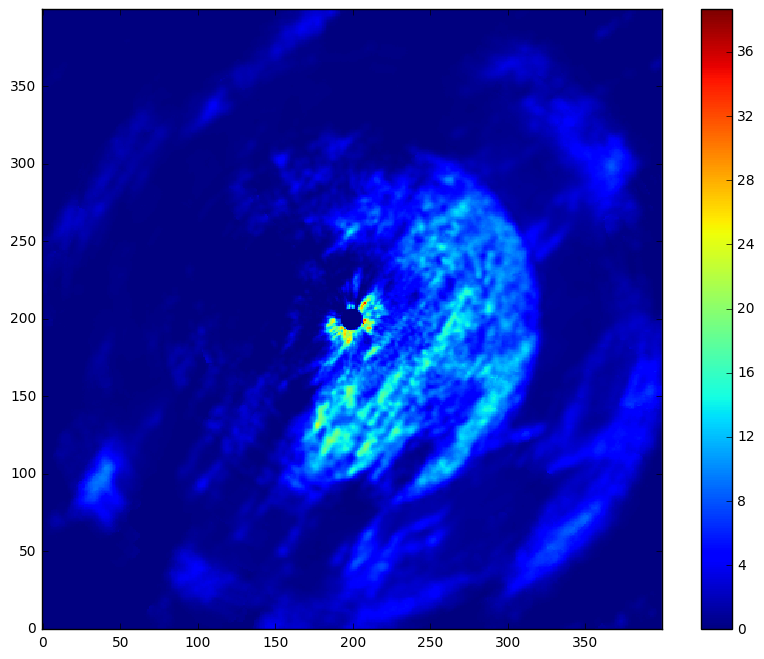

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
c = ax.imshow(rain, origin='lower', interpolation='None', vmin=0)
plt.colorbar(c)
plt.show()

In [44]:
lat = m.point_latitude['data'][0]
lon = m.point_longitude['data'][0]

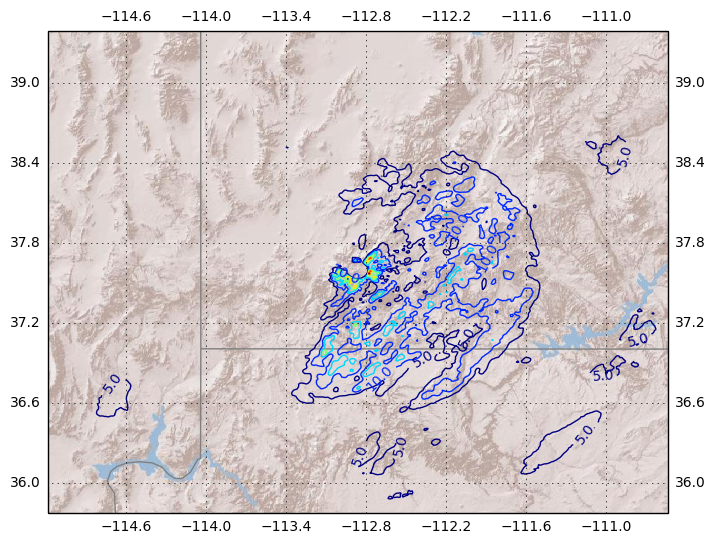

In [54]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
cl = ax.contour(lon, lat, rain)
cl.clabel(fmt='%1.1f')
ax.gridlines(draw_labels=True)
ax.add_image(ShadedReliefESRI(), 8)
ax.add_feature(states_provinces, edgecolor='gray')